In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd

In [4]:
data = pd.read_csv('C:/Users/Aravind/PROJECTS/Enefit-Predicting-Energy-Behavior/Enefit/data/external/train.csv')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018352 entries, 0 to 2018351
Data columns (total 9 columns):
 #   Column              Dtype  
---  ------              -----  
 0   county              int64  
 1   is_business         int64  
 2   product_type        int64  
 3   target              float64
 4   is_consumption      int64  
 5   datetime            object 
 6   data_block_id       int64  
 7   row_id              int64  
 8   prediction_unit_id  int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 138.6+ MB


In [6]:
data.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2


In [7]:
test_data = pd.read_csv('C:/Users/Aravind/PROJECTS/Enefit-Predicting-Energy-Behavior/Enefit/data/external/test.csv')

In [8]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12480 entries, 0 to 12479
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   county               12480 non-null  int64 
 1   is_business          12480 non-null  int64 
 2   product_type         12480 non-null  int64 
 3   is_consumption       12480 non-null  int64 
 4   prediction_datetime  12480 non-null  object
 5   data_block_id        12480 non-null  int64 
 6   row_id               12480 non-null  int64 
 7   prediction_unit_id   12480 non-null  int64 
 8   currently_scored     12480 non-null  bool  
dtypes: bool(1), int64(7), object(1)
memory usage: 792.3+ KB


In [9]:
test_data.head()

,county,is_business,product_type,is_consumption,prediction_datetime,data_block_id,row_id,prediction_unit_id,currently_scored
0,0,0,1,0,2023-05-28 00:00:00,634,2005872,0,False
1,0,0,1,1,2023-05-28 00:00:00,634,2005873,0,False
2,0,0,2,0,2023-05-28 00:00:00,634,2005874,1,False
3,0,0,2,1,2023-05-28 00:00:00,634,2005875,1,False
4,0,0,3,0,2023-05-28 00:00:00,634,2005876,2,False


In [10]:
test_data['currently_scored'].value_counts()

currently_scored
False    12480
Name: count, dtype: int64

In [11]:
path = 'C:/Users/Aravind/PROJECTS/Enefit-Predicting-Energy-Behavior/Enefit/data/external/train.csv'
df = pd.read_csv(path , parse_dates=['datetime'])

In [15]:
df = df.sort_values("datetime").set_index("datetime")
df = df['target']

In [16]:
df.head()

datetime
2021-09-01     0.713
2021-09-01     7.620
2021-09-01     0.000
2021-09-01    21.099
2021-09-01     0.000
Name: target, dtype: float64

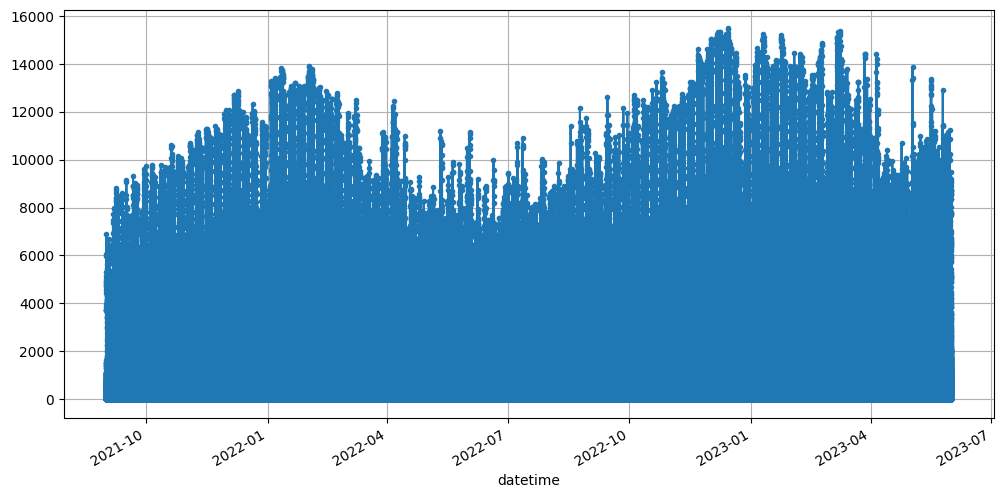

In [17]:
import matplotlib.pyplot as plt

df[:].plot(grid=True , marker='.' , figsize=(12,6))
plt.show()

In [18]:
train = df[:]["2021-09-01":"2022-10-06"] 
valid = df[:]["2022-10-07":"2023-01-29"] 
test = df[:]["2023-05-30":]

In [19]:
import tensorflow as tf

seq_length = 30
tf.random.set_seed(42)
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    train.to_numpy(),
    targets=train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    valid.to_numpy(),
    targets=valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [20]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate=0.01, epochs=20):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9 , nesterov=True)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae

In [21]:
tf.random.set_seed(42)
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(1)
])

In [22]:
fit_and_evaluate(model, train_ds, valid_ds)

Epoch 1/20
 2932/39280 [=>............................] - ETA: 16:57 - loss: nan - mae: nan